## Урок 5. Ранжирование и Гибридные рекоммендательные системы

In [6]:
# !pip install lightfm

# conda install -c conda-forge lightfm (если зависает !pip install)

from lightfm import *
# from lightfm import test_in_positives (возможно не сработает)

# (Взято с сайта, не проверено!  from ._lightfm_fast_no_openmp import *  # NOQA
#     from ._lightfm_fast_no_openmp import __test_in_positives  # NOQA)

from lightfm import LightFM

In [7]:
# проверка работоспособности
# from lightfm.datasets import fetch_movielens
# data = fetch_movielens(min_rating=4.0)
# display(data)
# model = LightFM(loss='warp')
# model.fit(data['train'], epochs=30, num_threads=2)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'
from time import time
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix, coo_matrix

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

from recsys_utils import prefilter_items

In [9]:
data = pd.read_csv('recsys_retail_train.csv')

item_features = pd.read_csv('recsys_product.csv')
user_features = pd.read_csv('recsys_hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [11]:
n_items_before = data_train['item_id'].nunique()

data_train_filtered = prefilter_items(data_train, group_col='item_id', popular_col='quantity', top_popular_filter_choose=5000)

n_items_after = data_train_filtered['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Отфильтровано 829774 записей
Decreased # items from 86865 to 5001


In [12]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix)

In [13]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]

test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float) # необходимый тип матрицы для implicit

In [14]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [15]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)
user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

item_feat.head(2)

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
item_id,,,,,,
202291,69.0,MISC SALES TRAN,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,
397896,69.0,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


In [17]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())
user_feat_lightfm.head(2)

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,income_desc_100-124K,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
%%time
score_dict_warp = {}
for no_components in tqdm(range(10, 51, 10)):
    for lr in (np.linspace(0.05, 0.22, 5)):
        model = LightFM(no_components=no_components,
                        #                 loss='bpr',
                        loss='warp',
                        learning_rate=lr,
                        item_alpha=0.1,
                        user_alpha=0.1,
                        random_state=13)

        model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                  sample_weight=coo_matrix(user_item_matrix),
                  user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                  item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                  epochs=15,
                  num_threads=4,
                  verbose=False)

        test_precision = precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(),
                                        user_features=csr_matrix(
                                            user_feat_lightfm.values).tocsr(),
                                        item_features=csr_matrix(
                                            item_feat_lightfm.values).tocsr(),
                                        k=5).mean()

        score_dict_warp[f'com{no_components}_reg{round(lr,3)}'] = test_precision


100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:10:33<00:00, 846.74s/it]

Wall time: 1h 10min 33s


In [27]:
%%time
score_dict_bpr = {}
for no_components in range(10, 51, 10):
    for lr in (np.linspace(0.05, 0.22, 5)):
        model = LightFM(no_components=no_components,
                        loss='bpr',

                        learning_rate=lr,
                        item_alpha=0.1,
                        user_alpha=0.1,
                        random_state=13)

        model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                  sample_weight=coo_matrix(user_item_matrix),
                  user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                  item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                  epochs=15,
                  num_threads=4,
                  verbose=False)

        test_precision = precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(),
                                        user_features=csr_matrix(
                                            user_feat_lightfm.values).tocsr(),
                                        item_features=csr_matrix(
                                            item_feat_lightfm.values).tocsr(),
                                        k=5).mean()

        score_dict_bpr[f'com{no_components}_reg{round(lr,3)}'] = test_precision

Wall time: 1h 13min 59s


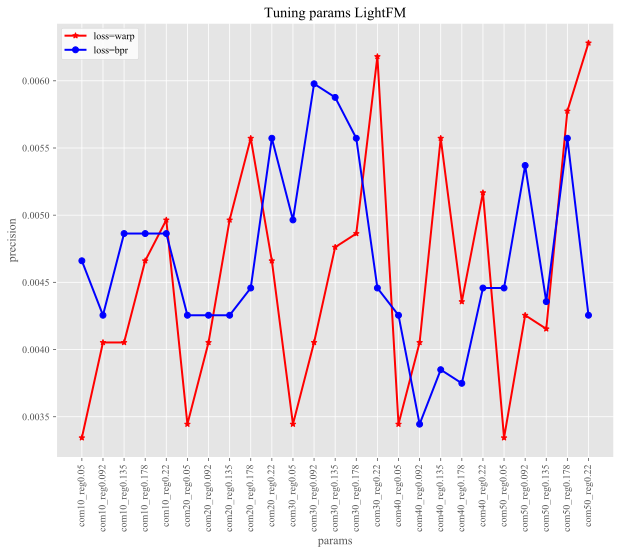

In [50]:
plt.figure(figsize=(10, 8))
plt.xlabel('params')
plt.ylabel('precision')
plt.title('Tuning params LightFM')
plt.plot(list(score_dict_warp.keys()), list(score_dict_warp.values()), color='r',
         marker='*',  linewidth=2, label="loss=warp",)
plt.plot(list(score_dict_bpr.keys()), list(score_dict_bpr.values()), color='b',
         marker='o',  linewidth=2, label="loss=bpr",)
plt.xticks(rotation=90)
plt.legend(loc='best', facecolor='white')
plt.show()